# Emojispace: Visualizing twitter messages based on emojis

## By: Eric S. Tellez

This example creates a vector space model for classify emojis in Twitter messages, then process and create vectors from messages and project them using a UMAP model. The projection uses the SimilaritySearch `allknn` operation.

Note: this notebook must be run with Jupyter and the environment variable JULIA_NUM_THREADS=auto

In [1]:
using Pkg
Pkg.activate(".")
Pkg.add([
    PackageSpec(name="SimilaritySearch", version="0.9"),
    PackageSpec(name="SimSearchManifoldLearning", version="0.2"),
    PackageSpec(name="TextSearch", version="0.12"),
    PackageSpec(name="CodecZlib"),
    PackageSpec(name="CategoricalArrays"),
    PackageSpec(name="JSON"),
    PackageSpec(name="JLD2"),
    PackageSpec(name="Plots")
])

using SimilaritySearch, SimSearchManifoldLearning, TextSearch, CodecZlib, JSON, JLD2, CategoricalArrays, Plots, LinearAlgebra
using Downloads: download

  Activating project at `~/Research/SimilaritySearchDemos/emojispace`
    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/Research/SimilaritySearchDemos/emojispace/Project.toml`
  No Changes to `~/Research/SimilaritySearchDemos/emojispace/Manifest.toml`


# Functions to parse and vectorize texts

In [2]:
function parse_corpus(corpusfile)
    labels = String[]
	corpus = String[]
    
	open(corpusfile) do f
		for line in eachline(GzipDecompressorStream(f))
			r = JSON.parse(line)
			push!(labels, r["klass"])
			push!(corpus, r["text"])    
		end
	end
    
    corpus, categorical(labels)
end

function text_model_and_vectors(corpus, labels)
    textconfig = TextConfig(group_usr=true, group_url=true, del_diac=true, lc=true, group_num=true, nlist=[1], qlist=[])
    model = VectorModel(EntropyWeighting(), TfWeighting(), textconfig, corpus, labels; mindocs=3, smooth=1.0)
	#model = VectorModel(IdfWeighting(), TfWeighting(), textconfig, corpus; mindocs=3)
    
	vectors = vectorize_corpus(model, textconfig, corpus)
    
	for v in vectors
		normalize!(v)
	end

    (; textconfig, model, vectors, labels)
end

function create_dataset(corpusfile)
    corpus, labels = parse_corpus(corpusfile)
    text_model_and_vectors(corpus, labels)
end
	
function create_index(db, indexfile)
    db = VectorDatabase(db)
    dist = NormalizedCosineDistance()
    G = SearchGraph(; db, dist, verbose=false)
    index!(G; parallel_block=512)
    optimize!(G, MinRecall(0.9))
    G
end

create_index (generic function with 1 method)

# Downloading the dataset, parsing and vectorizing functions

In [3]:
dbfile = "emo50k.json.gz"
indexfile = "emojis-index.jld2"
umapfile = "emojis-umap-embeddings.jld2"
baseurl = "https://github.com/sadit/TextClassificationTutorial/blob/main/data"

!isfile(dbfile) && download("$baseurl/$dbfile?raw=true", dbfile)
D = create_dataset(dbfile)
@info "this can take a while depending on the number of threads and the speed of your system"
# we use Exhaustive search instead of `SearchGraph` (create_index) because the dataset is quite small
# and high dimensional, these both are bad combinations for any index
index = ExhaustiveSearch(; db=D.vectors, dist=NormalizedCosineDistance()) # create_index(D.vectors, indexfile)
length(index)

┌ Info: this can take a while depending on the number of threads and the speed of your system
└ @ Main In[3]:8


50000

# Functions to create low dimensional projections

In [4]:
function load_or_create_umap_embeddings(index, umapfile; force=true, k=50, n_epochs=100, neg_sample_rate=3, tol=1e-3, layout=RandomLayout())
	if force || !isfile(umapfile)
		#layout = RandomLayout()
		# increase both `n_epochs` and `neg_sample_rate` to improve projection
		#layout = SpectralLayout() ## the results are much better with Spectral layout
		@time U2 = fit(UMAP, index; k, neg_sample_rate, layout, n_epochs, tol)  # spectral layout is too slow for the input-data
		@time U3 = fit(U2, 3; neg_sample_rate, n_epochs, tol)  # reuses U2
		jldsave(umapfile, e2=U2.embedding, e3=U3.embedding)
		(e2=U2.embedding, e3=U3.embedding)
    else
        e2, e3 = load(umapfile, "e2", "e3")
		(e2=e2, e3=e3)
	end
end

function normcolors(V)
    min_, max_ = extrema(V)
    V .= (V .- min_) ./ (max_ - min_)
    V .= clamp.(V, 0, 1)
end

function plot_umap(e2, e3)
    normcolors(@view e3[1, :])
    normcolors(@view e3[2, :])
    normcolors(@view e3[3, :])

    C = [RGB(c...) for c in eachcol(e3)]
    X = @view e2[1, :]
    Y = @view e2[2, :]
    P = scatter(X, Y, c=C, fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="", yticks=nothing, xticks=nothing, xaxis=false, yaxis=false)
    display(plot!(title="colors are related to spatial proximity in the 3d projection")) 
    scatter(X, Y, c=levelcode.(D.labels), fmt=:png, size=(600, 600), ma=0.3, a=0.3, ms=2, msw=0, label="", color_palette=:rainbow)
    plot!(title="colors are related to labels")
    #S = rand(1:length(X), 200)
    #annotate!(X[S], Y[S], text.(D.labels[S], 0.3, 8, "NotoColorEmoji"))
end

plot_umap (generic function with 1 method)

# Visualizations

UMAP projection can take a while, even on multithreading systems. Note that we are creating 2d and 3d projections

In [5]:
e2, e3 = load_or_create_umap_embeddings(index, umapfile);

 35.088746 seconds (447.90 k allocations: 44.393 MiB, 0.31% compilation time)
 39.977453 seconds (1.85 M allocations: 349.108 MiB, 0.92% gc time, 2.50% compilation time)
  7.779852 seconds (1.67 k allocations: 1.392 MiB, 0.11% compilation time)


*** computing graph
*** layout embedding RandomLayout
*** fit ab / embedding
*** opt embedding
UMAP construction time cost report:
- fuzzy graph: 0.974611388
- embedding init: 0.000633036
- embedding opt: 3.238572307



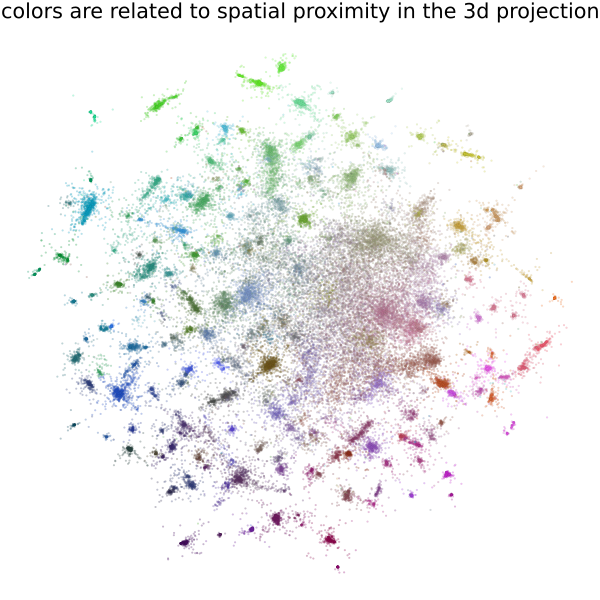

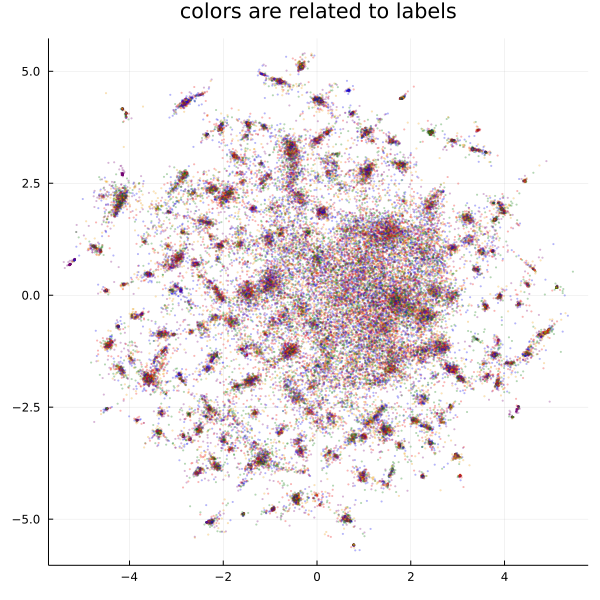

In [6]:
plot_umap(e2, e3)

# Final notes
The final projections show that while spatial distance is quite preserved (3d and 2d), the colors based on labels are more or less mixed in many of the visible clusters. This is an indicator that other models may provide better results while using distance based classifiers. However, improving this models are beyond the scope of this example notebook.

Parsing and analyzing text is made with `TextSearch` and low dimensional projections with `SimSearchManifoldLearning`. `SimilaritySearch` is used for computing the all $k$ nearest neighbors needed by the UMAP model. Note that this notebook should be ran with several threads to reduce time costs.

The precise packages used in this example are listed below

In [7]:
Pkg.status()

      Status `~/Research/SimilaritySearchDemos/emojispace/Project.toml`
  [324d7699] CategoricalArrays v0.10.6
  [944b1d66] CodecZlib v0.7.0
  [033835bb] JLD2 v0.4.22
  [682c06a0] JSON v0.21.3
  [91a5bcdd] Plots v1.30.1
  [ca7ab67e] SimSearchManifoldLearning v0.2.4
  [053f045d] SimilaritySearch v0.9.2
  [7f6f6c8a] TextSearch v0.12.2
